# Fighting fire with firepower
## Part 2: Deploying a neural network
<br>
<br>

> Wayne Chan <br>
> Mariam Javed <br>
> Shawn Syms 

<a name="contents"></a>
## Contents

- [Imports](#Imports)
> - [Preprocessing](#Preprocessing)
> - [Feature engineering](#Feature-engineering)
> - [Modeling](#Modeling)
- [Neural Network: Feed Forward](#Neural-Network:-Feed-Forward)

## Imports

In [ ]:
import datetime
import numpy as np
import pandas as pd

# presentation and visualization
import seaborn as sns
import matplotlib.pyplot as plt

# keras
from keras.layers import Dense
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras import utils


# sci-kit learn 
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, train_test_split 
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, StandardScaler

<div style="text-align: right">(<a href="#contents">home</a>) </div>

## Preprocessing

In [ ]:
# Read in the data

df = pd.read_csv('fire_size_class.csv')

In [3]:
# Adjust column name case

df.columns = map(str.lower, df.columns)

In [ ]:
# Eliminate artefact of csv import

df.drop('unnamed: 0', axis = 1, inplace = True)

In [5]:
df.shape

(1880465, 11)

In [ ]:
#let's combine all of the date columns into a single date column

df['datetime'] = df['fire_year'].astype(str) + df['discovery_doy'].astype(str)

new_list = []

for i in df['datetime']:
    
    dt = datetime.datetime.strptime(i, '%Y%j').strftime('%d/%m/%Y')
    new_list.append(dt)
    
df['dmy'] = new_list

In [ ]:
# Reorder columns

cols = df.columns.tolist()
cols = ['fire_year', 'discovery_date', 'discovery_doy', 'discovery_time', 'datetime', 'dmy',
       'stat_cause_descr', 'latitude', 'longitude', 'state', 'fire_code',
       'fire_size', 'fire_size_class']
df = df[cols]

#rename dmy and stat_cause_descr columns

df.rename(columns={'dmy': 'fire_date', 'stat_cause_descr': 'fire_cause'}, inplace = True)

In [8]:
# How many nulls do we have?

df.isnull().sum()

fire_year                0
discovery_date           0
discovery_doy            0
discovery_time      882638
datetime                 0
fire_date                0
fire_cause               0
latitude                 0
longitude                0
state                    0
fire_code          1555741
fire_size                0
fire_size_class          0
dtype: int64

In [ ]:
# Drop fire_code column

df.drop('fire_code', axis = 1, inplace = True)

Let's create a function for label encoding and apply it to the df:

In [12]:
# Create functions for label_encoding 

def label_encoding(df, col_name):
    le = LabelEncoder()
    df[col_name] = le.fit_transform(df[col_name])
    return df.head()

label_encoding(df, 'fire_cause')
label_encoding(df, 'fire_size_class')

fire_year  discovery_date  discovery_doy  discovery_time datetime  \
0       2005       2453403.5             33          1300.0   200533   
1       2004       2453137.5            133           845.0  2004133   
2       2004       2453156.5            152          1921.0  2004152   
3       2004       2453184.5            180          1600.0  2004180   
4       2004       2453184.5            180          1600.0  2004180   

    fire_date  fire_cause   latitude   longitude state  fire_size  \
0  02/02/2005           7  40.036944 -121.005833    CA       0.10   
1  12/05/2004           6  38.933056 -120.404444    CA       0.25   
2  31/05/2004           3  38.984167 -120.735556    CA       0.10   
3  28/06/2004           6  38.559167 -119.913333    CA       0.10   
4  28/06/2004           6  38.559167 -119.933056    CA       0.10   

   fire_size_class  
0                0  
1                0  
2                0  
3                0  
4                0

Let's drop the fire_size column because it's directly correlated to the fire_size_class column:

In [13]:
df.drop('fire_size', axis = 1, inplace = True)

<div style="text-align: right">(<a href="#contents">home</a>) </div>

## Feature engineering

In [ ]:
# Longitude and latitude or normally used together; let's create a new column that combines them

df['longlat'] = df['longitude'] * df['latitude']

# We know that the time of year and the location play a role in fires

df['timelocation'] = df['longlat'] * df['discovery_time'] * df['discovery_date']

In [ ]:
df['cause_timelocation'] = df['fire_cause'] * df['timelocation']

In [ ]:
df['doy_time_location'] = df['discovery_doy'] * df['timelocation']

Let's also create some polynomial features:

In [21]:
# Create polynomial features excluding year and date

features = ['fire_year', 'discovery_date', 'discovery_doy',
       'datetime','fire_cause', 'latitude', 'longitude', 'longlat']

X = df[features]
y = df['fire_size_class']

In [22]:
poly = PolynomialFeatures(include_bias = False)
X_poly = poly.fit_transform(X)

df = pd.DataFrame(data = X_poly, columns = poly.get_feature_names(features))

# Add target back

df['fire_size_class'] = y

In [ ]:
# Let's create a subset of the dataframe to work with

df = df.groupby('fire_year').apply(lambda x: x.sample(10_000)).reset_index(drop=True)

In [28]:
df.shape

(240000, 45)

<div style="text-align: right">(<a href="#contents">home</a>) </div>

## Modeling

In [29]:
# Set features and target variables

X = df.drop(['fire_size_class'], axis = 1)
y = df['fire_size_class']

In [30]:
# Set up our train-test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

Our baseline estimator:

In [31]:
y_test.value_counts(normalize = True)

1    0.497417
0    0.358500
2    0.116292
3    0.014375
4    0.007479
5    0.003938
6    0.002000
Name: fire_size_class, dtype: float64

In [32]:
df.shape

(240000, 45)

Let's train a Neural Network!

<div style="text-align: right">(<a href="#contents">home</a>) </div>

## Neural Network: Feed Forward

In [36]:
# Configure our y as the array that Keras expects

y_train = utils.to_categorical(y_train, 7)
y_test = utils.to_categorical(y_test, 7)

In [37]:
# Apply standard scaling

ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

# Establish network topology
model = Sequential()
model.add(Dense(256, input_shape = (44,), activation = 'relu'))
model.add(Dropout(0.5)) #can add drop out here
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(7, activation = 'softmax'))

# Compile NN model
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [38]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               11520     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 7)                 455       
Total params: 53,127
Trainable params: 53,127
Non-trainable params: 0
_________________________________________________________________


In [39]:
# Early stopping:
# Patience tells the model how many epochs to be looking for to see improvement
# Min delta is a threshold, so any loss or increase that occurs is an improvement

early_stop = EarlyStopping(monitor = 'val_loss', patience = 5, min_delta = 0, restore_best_weights = True) 

#fit the model

history = model.fit(X_train_sc, y_train, validation_data = (X_test_sc, y_test), epochs = 100, batch_size = 32)

Instructions for updating:
Use tf.cast instead.
Train on 192000 samples, validate on 48000 samples
Epoch 1/100
192000/192000 [==============================] - 17s 88us/step - loss: 1.0105 - accuracy: 0.5880 - val_loss: 0.9753 - val_accuracy: 0.6018
Epoch 2/100
192000/192000 [==============================] - 19s 101us/step - loss: 0.9868 - accuracy: 0.5961 - val_loss: 0.9697 - val_accuracy: 0.6059
Epoch 3/100
192000/192000 [==============================] - 15s 76us/step - loss: 0.9789 - accuracy: 0.5979 - val_loss: 0.9608 - val_accuracy: 0.6063
Epoch 4/100
192000/192000 [==============================] - 14s 75us/step - loss: 0.9744 - accuracy: 0.5993 - val_loss: 0.9592 - val_accuracy: 0.6057
Epoch 5/100
192000/192000 [==============================] - 19s 97us/step - loss: 0.9706 - accuracy: 0.6002 - val_loss: 0.9559 - val_accuracy: 0.6092
Epoch 6/100
192000/192000 [==============================] - 17s 88us/step - loss: 0.9682 - accuracy: 0.6007 - val_loss: 0.9540 - val_accuracy: 0

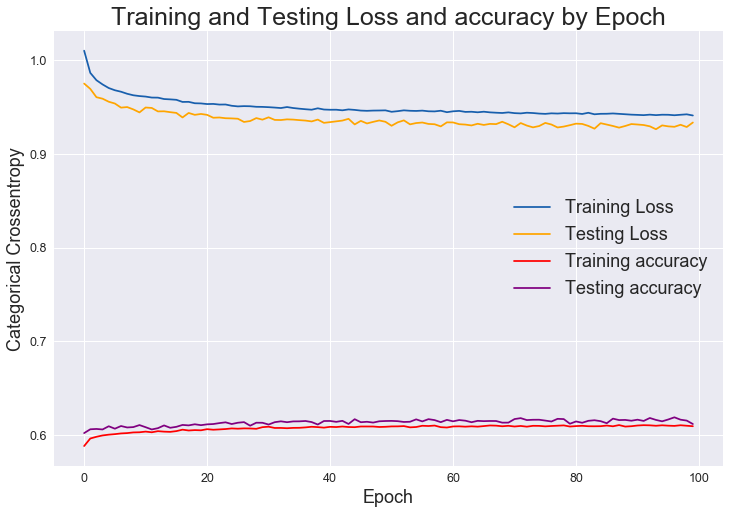

In [43]:
# Check out our train loss and test loss over epochs.

train_loss = history.history['loss']
test_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']

# Set figure size.

plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.

plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Generate line plot of training, testing loss over epochs.

plt.plot(train_accuracy, label='Training accuracy', color='red')
plt.plot(test_accuracy, label='Testing accuracy', color='purple')

# Set title

plt.title('Training and Testing Loss and accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)

plt.legend(fontsize = 18);

<div style="text-align: right">(<a href="#contents">home</a>) </div>